# Image Stitching by manual correspondences selection
This notebook contains the code that allows to stitch images after having manually selected the point correspondences between a couple of images.

## Importing libraries

In [1]:
import cv2 as cv
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
from IPython.display import Audio, display
import ipynb.fs.defs.Utils as Utils
import ipynb.fs.defs.GraphBuilding as GraphBuilding

## Variables definition

In [2]:
#Directories
dataset_name = 'mountain_dataset' #Name of the dataset to be used
dataset_dir = f'datasets/{dataset_name}' #Name of the folder where the dataset is stored
output_dir ="output" #Name of the folder where to store the output
stitching_dir = "stitched" #Name of the folder where to store the stitched image
partial_results_dir = "partial" #Name of the folder where to store partial results
gt_dir = f"ground_truth/{dataset_name}" #Name of the folder where to store the gt

In [3]:
#Global variables
save_output = True
save_images = True
output_dir ="output"
results_dir = "results"
verbose = False

In [4]:
#Simple graph parameters
simple_matching_threshold = 0.6 #Treshold used to select matches
simple_matches_th = 10 #Treshold used to select salient matches
simple_RANSACmaxIters = 2000 #Number of RANSAC iterations
load_simple_matrices = True #If true allows to load the already computed matrices

In [5]:
#General stitching parameters
automatic_idx_computation = True #If True allows to automatically compute the reference image
idx_ref = 0 #Index of the reference image
idxs = None #Array of images indexes to be stitched (if None all images are stitched)
beautify = True #If True allows to print the stitched image in a better way

In [7]:
#Load images from the folder
imgs = Utils.load_images_from_folder(dataset_dir)
imgs_duplicates = [img.copy() for img in imgs]

In [8]:
M, Z, C, adj_matrix, weight_matrix = GraphBuilding.build_graph_matrices(dataset_name,
            imgs_duplicates,
            matching_threshold = simple_matching_threshold,
            number_of_matches=1,
            matches_th = simple_matches_th ,
            RANSACmaxIters = simple_RANSACmaxIters,
            save_output = save_output,
            save_images = save_images,
            output_dir = output_dir,
            results_dir = results_dir,
            verbose = verbose)

In [9]:
if automatic_idx_computation:
    idx_ref = Utils.get_reference_node(adj_matrix)

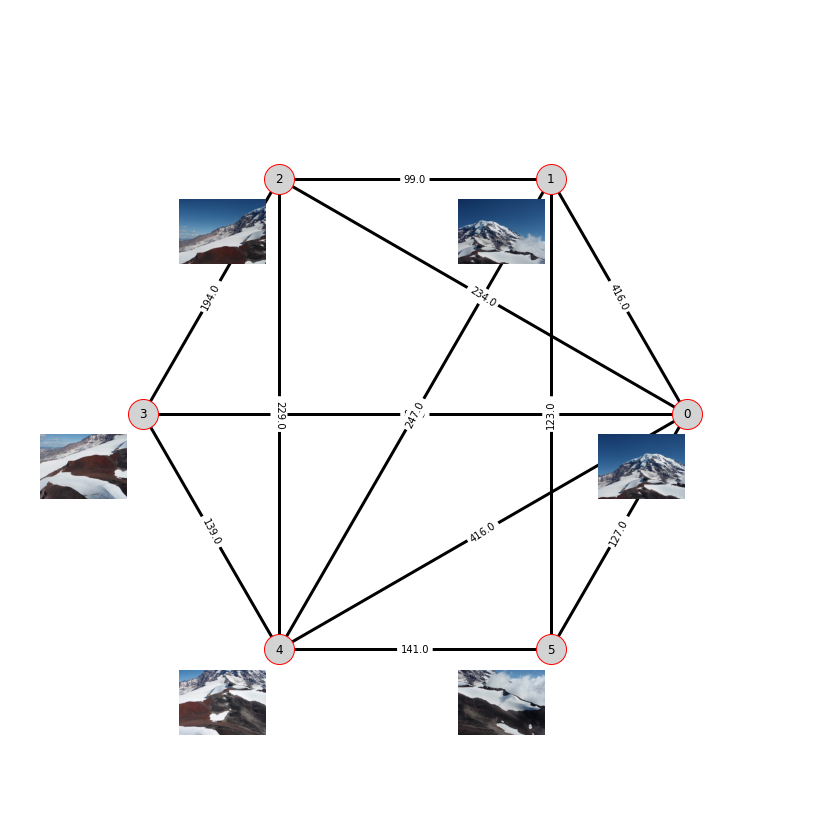

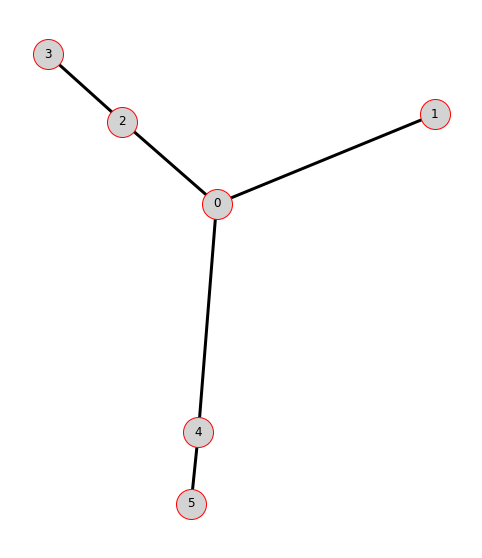

In [10]:
graph = Utils.build_and_print_graph(imgs, 
                                  adj_matrix, 
                                  weight_matrix, 
                                  save_output, 
                                  output_dir,
                                  "graph")

spanning_tree = nx.maximum_spanning_tree(graph)

Utils.print_graph(spanning_tree, save_output, output_dir, "spanning-tree")

In [11]:
idx_ref

0

In [12]:
def resize_crop_img(img, x, y, zoom_ratio):
    point = np.array([x,y])
    size = np.array(img.shape[:2])[::-1]

    scaled_size = (size*zoom_ratio).astype(int)
    resized_img = cv.resize(img, scaled_size, interpolation = cv.INTER_AREA)
    
    ul_corner = np.minimum(np.maximum([0,0],point-size/2),scaled_size - size).astype(int)
    
    cropped_img = resized_img[ul_corner[1]:ul_corner[1]+size[1], ul_corner[0]:ul_corner[0]+size[0]]
    
    t = -ul_corner
    Ht = np.array([[zoom_ratio,0,t[0]],[0,zoom_ratio,t[1]],[0,0,1]])
    
    return cropped_img, Ht

In [13]:
def click_event(event, x, y, flags, params):
    image_name, img, points, zoomed_img, Ht = params
    
    zoom_ratio = 1.2
     
    # checking for left mouse clicks
    if event == cv.EVENT_LBUTTONDOWN:
        zoomed_point = [x,y,1]
        # displaying the coordinates
        # on the Shell
        #print(x, ' ', y)
        projected_point = np.linalg.inv(Ht)@zoomed_point
        projected_point /= projected_point[2]
        projected_point = projected_point.astype(int)
        points.append(projected_point[:2])
        x,y = projected_point[0],projected_point[1]
        #print(points)
 
        # displaying the coordinates
        # on the image window
        font = cv.FONT_HERSHEY_SIMPLEX
        cv.putText(img, str(x) + ',' +
                    str(y), (x,y), font,
                    1, (255, 0, 0), 2)
        cv.putText(zoomed_img, str(x) + ',' +
                    str(y), zoomed_point[:2], font,
                    1, (255, 0, 0), 2)
        cv.imshow(image_name, cv.cvtColor(zoomed_img,cv.COLOR_RGB2BGR))
        
    if event == cv.EVENT_MOUSEWHEEL:
        size = img.shape
        
        if flags < 0:
            cv.imshow(image_name, cv.cvtColor(img,cv.COLOR_RGB2BGR))
            np.copyto(Ht,np.eye(3))
            np.copyto(zoomed_img,img)
        else:
            resized_img, Ht_new = resize_crop_img(zoomed_img, x, y, zoom_ratio)
            np.copyto(Ht,Ht_new@Ht)
            
            np.copyto(zoomed_img,resized_img)
            cv.imshow(image_name, cv.cvtColor(zoomed_img,cv.COLOR_RGB2BGR))


In [14]:
def compute_scaling(img, final_size = np.array([900 , 1000])):
    img_size = np.array(img.shape[:2])
    scaling = (min(final_size / img_size))
    dim = (img_size*scaling).astype(int)[::-1]
    H_scaling = np.diag([scaling,scaling,1])
    return dim, H_scaling

In [15]:
def compute_homography(base_img,img):
    base_img_name = 'base_image'
    image_name = 'image'
    
    points = list()
    base_points = list()
    
    dim_base, H_scal_base = compute_scaling(base_img)
    dim, H_scal = compute_scaling(img)
    
    # resize image
    img_res = cv.resize(img, dim, interpolation = cv.INTER_AREA)
    base_img_res = cv.resize(base_img, dim_base, interpolation = cv.INTER_AREA)
    
    cv.imshow(image_name,cv.cvtColor(img_res,cv.COLOR_RGB2BGR) )
    cv.imshow(base_img_name,cv.cvtColor(base_img_res,cv.COLOR_RGB2BGR) )
    
    cv.setMouseCallback(image_name, click_event, [image_name,img_res.copy(),points,img_res.copy(), np.eye(3)])
    cv.setMouseCallback(base_img_name, click_event, [base_img_name,base_img_res.copy(),base_points,base_img_res.copy(), np.eye(3)])
 
    # wait for a key to be pressed to exit
    cv.waitKey(0)
 
    # close the window
    cv.destroyAllWindows()
    
    if len(points) < 4 or len(base_points) < 4:
        print("select at least 4 couple of points")
        return compute_homography(base_img,img)
    
    points = np.array(points)
    base_points = np.array(base_points)
    
    H,_ = cv.findHomography(points, base_points) # original plane to target plane
    
    #print(H)
    
    H_resized =  np.linalg.inv(H_scal_base) @ H @ H_scal
    
    Hs = [np.eye(3), H_resized]
    
    stitcher = Utils.ImageStitcher([base_img,img])
    Ht, stitched = stitcher.stitch_images_denorm( Hs, 0, beautify=True)
    
    figure(figsize=(40, 40), dpi=80)
    plt.imshow(stitched,)
    plt.show() 

    return stitched, H_resized, Ht

In [16]:
def stitch_pair(imgs, base_img, node_idx, father_idx, st_graph, H_dict, translation = np.eye(3)):
    for n in st_graph[node_idx]:
        if n != father_idx:
            print(n)
            base_img, H, Ht = compute_homography(base_img,imgs[n])
            H_dict[n] = np.linalg.inv(translation) @ H
            translation = Ht @ translation
            base_img, translation = stitch_pair(imgs, base_img, n, node_idx, st_graph, H_dict, translation)
    return base_img, translation

1
select at least 4 couple of points
[0, 0]


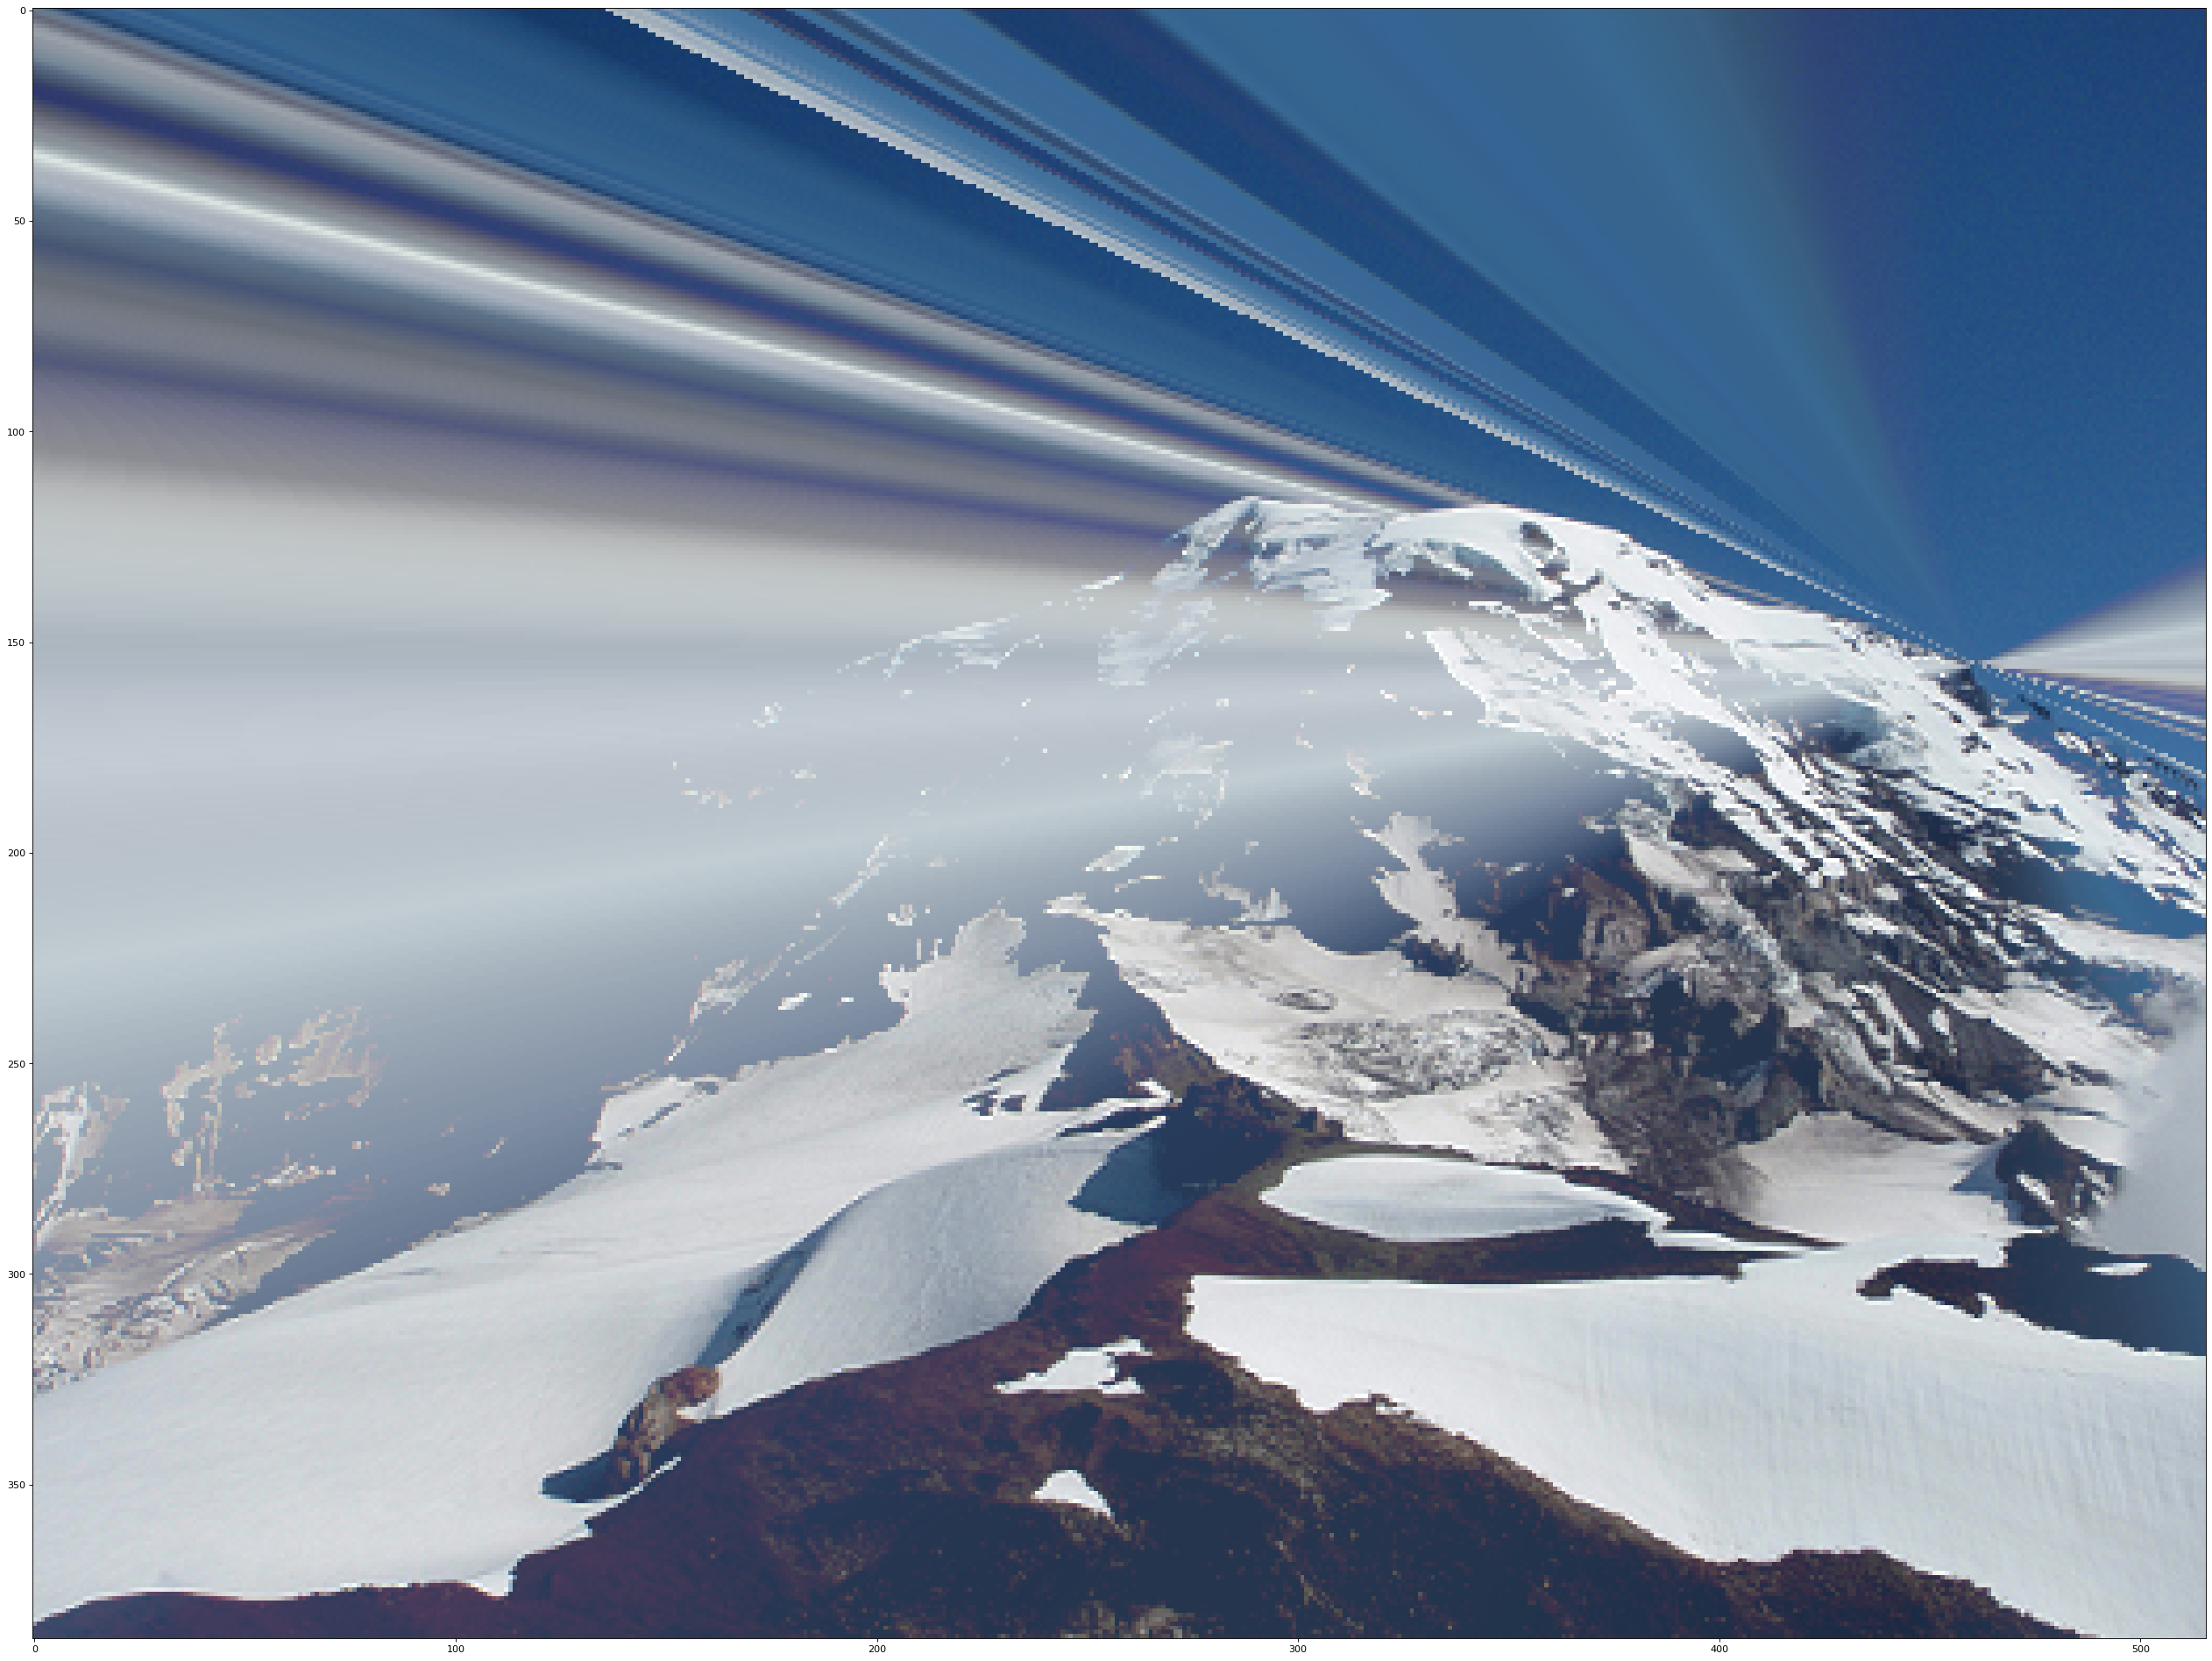

4


In [ ]:
H_dict = dict()
stitched = imgs[idx_ref].copy()
_ = stitch_pair(imgs, stitched, idx_ref, idx_ref, spanning_tree, H_dict)

In [ ]:
Hs = []
for i in range(len(imgs)):
    if i== idx_ref:
        Hs.append(np.eye(3))
    else:
        Hs.append(H_dict[i])

In [ ]:
stitcher = Utils.ImageStitcher(imgs)
Ht, stitched = stitcher.stitch_images_denorm( Hs, idx_ref, beautify=True)

figure(figsize=(40, 40), dpi=80)
plt.imshow(stitched,)
plt.show() 

In [ ]:
if not os.path.isdir(gt_dir):
    os.makedirs(gt_dir)
np.save(os.path.join(gt_dir,f"{idx_ref}.npy"),np.array(Hs) )